# Analysis of the EA-LSTM catchment embedding

In this notebook we will go step-by-step through the section of the analysis of catchment similarity from the embedding layer.

For more information read the experiment description in our paper:

**TODO**: Include Ref

Note:
If you want to run this notebook locally and reproduce the figures of our paper
- make sure you have our pre-trained models. See the [README.md](link) in the repository for further instructions.

- make sure to have the CAMELS data set, containing the updated Maurer forcings. See the [README.md](link) in the repository for further instructions.


#### Adapt the lines below according to your local system

In [1]:
# Path to the main CAMELS folder
CAMELS_DIR = "/datadisk/data/CAMELS/"

# Path to the main directory of this repository
BASE_CODE_DIR = "/home/frederik/projects/ealstm_in_hydrology"

# Needed if no precomputed results are used. Path to a single run
BASE_RUN_DIR = "/datadisk/data/EALSTM_PAPER/runs/run_1906_1004_seed111"

# Filename of precomputed results
EMBEDDING_FILE = "run_1906_1004_seed111_catchment_embedding.p"

In [2]:
# Imports
import json
import pickle
import sys
from collections import defaultdict
from pathlib import Path

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import umap
from bokeh.sampledata import us_states
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from tqdm import tqdm_notebook as tqdm

sys.path.append(BASE_CODE_DIR)
from main import Model
from papercode.clusterutils import get_silhouette_scores, get_clusters, get_label_2_color, get_variance_reduction
from papercode.datasets import CamelsTXT
from papercode.datautils import load_attributes
from papercode.plotutils import get_shape_collections
from papercode.utils import get_basin_list

# get polygon points of only the CONUS states
us_states = us_states.data.copy()
del us_states["HI"]
del us_states["AK"]

Definition of global variables.

**Note**: If you want to recompute the feature rankings (for possibly a different seed), change the PRECOMPUTED_RANKING flag to False. Having a GPU available is not of importance for this notebook, since extracting the catchment embeddings is a really simple task.

In [3]:
# True if using precomputed data
PRECOMPUTED_DATA = True

# Convert file/folder path to pathlib Path objects
CAMELS_DIR = Path(CAMELS_DIR)
BASE_RUN_DIR = Path(BASE_RUN_DIR)
EMBEDDING_FILE = Path(EMBEDDING_FILE)

# Not really of importance, but need to be defined for the data set class.
VAL_START = pd.to_datetime('01101989', format='%d%m%Y')
VAL_END = pd.to_datetime('30091999', format='%d%m%Y')


If the embeddings are re-calculated, we have to setup the model, load the pre-trained weights and extract the weights corresponding to the static feature embedding from the network.

In [4]:
basins = get_basin_list()

if not PRECOMPUTED_DATA:
    
    with open(BASE_RUN_DIR / "cfg.json", "r") as fp:
        cfg = json.load(fp)
    
    # load means/stds from training period
    attributes = load_attributes(db_path=str(BASE_RUN_DIR / "attributes.db"), 
                                 basins=basins,
                                 drop_lat_lon=True)
    means = attributes.mean()
    stds = attributes.std()

    # Initialize model
    model = Model(input_size_dyn=5,
                  input_size_stat=27,
                  hidden_size=cfg["hidden_size"],
                  dropout=cfg["dropout"])
    weight_file = BASE_RUN_DIR / "model_epoch30.pt"
    model.load_state_dict(torch.load(weight_file, map_location="cpu"))
    
    # extract weight and bias of input gate
    weight = model.lstm.weight_sh
    bias = model.lstm.bias_s

In this block of code, the input gate embeddings are re-calculated, outside of the original model, using the extracted weights from above. Otherwise, the pre-calculated embeddings are loaded

In [5]:
if not PRECOMPUTED_DATA:
    lstm_embedding = {}
    for basin in tqdm(basins):
        ds_test = CamelsTXT(camels_root=CAMELS_DIR,
                            basin=basin,
                            dates=[VAL_START, VAL_END],
                            is_train=False,
                            with_attributes=True,
                            attribute_means=means,
                            attribute_stds=stds,
                            db_path=str(BASE_RUN_DIR / "attributes.db"))
        input_gate = torch.sigmoid(torch.addmm(bias, ds_test.attributes, weight))
        lstm_embedding[basin] = input_gate.detach().numpy()
        
    out_file = f"{BASE_RUN_DIR.name}_catchment_embedding.p" 
    with open(out_file, "wb") as fp:
        pickle.dump(lstm_embedding, fp)
        
else:
    with EMBEDDING_FILE.open("rb") as fp:
        lstm_embedding = pickle.load(fp)
    print("Loaded pre-computed catchment embedding from file")
    
stacked_embedding = np.concatenate(list(lstm_embedding.values()))

Loaded pre-computed catchment embedding from file


Next we plot the calculated basin embeddings, derived from the adapted input gate of the EA-LSTM. Each column corresponds to on basin and the rows denote the input gate value of the 256 LSTM cells. The basins are ordered by ascending USGS gauge ids. These are increasing from the East to the West in the USA. 

Text(0, 0.5, 'Activation')

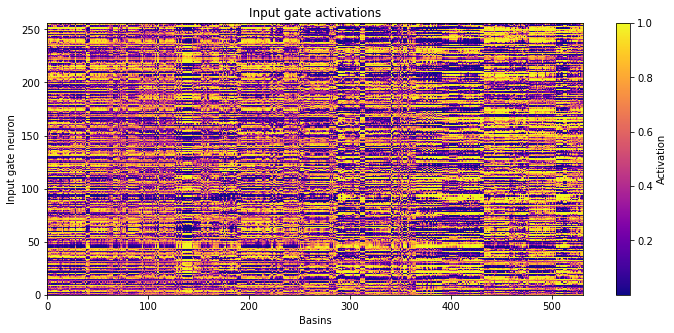

In [6]:
fig, ax = plt.subplots(figsize=(12,5))
img = ax.pcolor(stacked_embedding.T, cmap='plasma')
ax.set_xlabel("Basins")
ax.set_ylabel("Input gate neuron")
ax.set_title("Input gate activations")
cbar = plt.colorbar(img, ax=ax)
cbar.ax.set_ylabel("Activation")

# Cluster analysis
In the next step we use the LSTM catchment embedding, as well as the raw catchment attributes to perform cluster analysis.

Therefore, we perform the following steps:
1. Determine the optimal number _k_ of clusters for each of the two sets of features
2. Cluster the data using the _k_ determined in the previous step
3. Analyse the variance reduction due to the cluster results

In [7]:
# load raw attributes and normalize them feature-wise to zero mean, unit variance
df_raw = load_attributes(db_path=str(BASE_RUN_DIR / "attributes.db"), 
                             basins=basins, 
                             drop_lat_lon=True)
df_norm = (df_raw - df_raw.mean()) / df_raw.std()
raw_features = df_norm.values

## Silhouette scores

We calculate the mean and min silhouette scores for the embeddings of all eight EA-LSTMs and the raw (normalized) catchment attributes. We use the embeddings of all eight models to get a feeling for the uncertainty in the results.

In [8]:
print("==> Calculate mean/min silhouette scores for the EA-LSTM embedding")
lstm_scores_means = defaultdict(list)
lstm_scores_mins = defaultdict(list)
for embedding_file in tqdm(list(Path().glob('*embedding.p'))):
    with embedding_file.open("rb") as fp:
        lstm_embedding = pickle.load(fp)
    stacked_embedding = np.concatenate(list(lstm_embedding.values()))
    mean_scores, min_scores = get_silhouette_scores(stacked_embedding)
    for cluster, values in mean_scores.items():
        lstm_scores_means[cluster].append(values)
    for cluster, values in min_scores.items():
        lstm_scores_mins[cluster].append(values)

print("==> Calculate mean/min silhouette scores for the raw catchment attributes")
raw_scores_means, raw_scores_mins = get_silhouette_scores(raw_features)

==> Calculate mean/min silhouette scores for the EA-LSTM embedding



==> Calculate mean/min silhouette scores for the raw catchment attributes


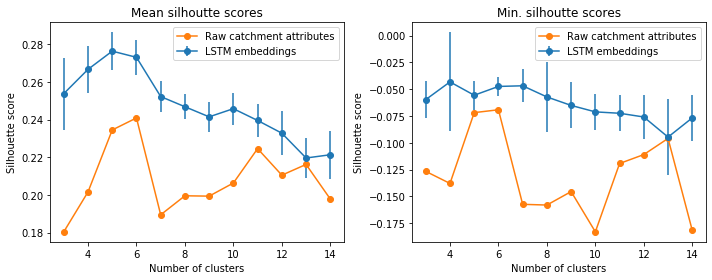

In [9]:
# Plot the results
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
ax[0].errorbar(x=list(lstm_scores_means.keys()), 
            y=[np.mean(vals) for vals in list(lstm_scores_means.values())],
            yerr = [np.std(vals) for vals in list(lstm_scores_means.values())],
            marker='o', 
            markevery=1,
            label="LSTM embeddings")
ax[0].plot(list(raw_scores_means.keys()), 
        list(raw_scores_means.values()), 
        marker='o', 
        markevery=1,
        label="Raw catchment attributes")
ax[0].set_xlabel("Number of clusters")
ax[0].set_ylabel("Silhouette score")
ax[0].set_title("Mean silhoutte scores")
ax[0].legend()
ax[1].errorbar(x=list(lstm_scores_mins.keys()), 
            y=[np.mean(vals) for vals in list(lstm_scores_mins.values())],
            yerr = [np.std(vals) for vals in list(lstm_scores_mins.values())],
            marker='o', 
            markevery=1,
            label="LSTM embeddings")
ax[1].plot(list(raw_scores_mins.keys()), 
        list(raw_scores_mins.values()), 
        marker='o', 
        markevery=1,
        label="Raw catchment attributes")
ax[1].set_xlabel("Number of clusters")
ax[1].set_ylabel("Silhouette score")
ax[1].set_title("Min. silhoutte scores")
ax[1].legend()
plt.tight_layout()

## k-means clustering
Using the results from above, next we calculate the cluster labels using the two optimal `k` values we found from the silhouette analysis (`k=5` and `k=6`). To make the plots visually easier to compare, we make sure that the color of the labels match between the plots.

In [10]:
# get the cluster labels for both feature sets and both k values
clusters = get_clusters(lstm_embedding, df_norm, ks=[5,6], basins=basins)

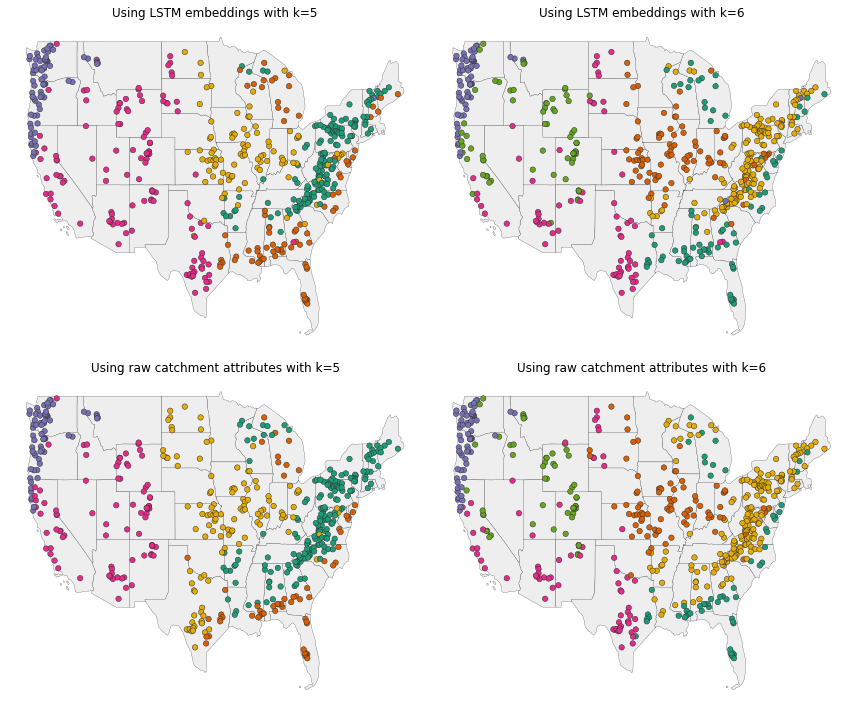

In [11]:
# draw the maps
attributes = load_attributes(db_path=str(BASE_RUN_DIR / "attributes.db"),
                             basins=basins,
                             drop_lat_lon=False)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

for i, k in enumerate(clusters.keys()):
    label_2_color = get_label_2_color(clusters[k]["lstm"], clusters[k]["raw"])
    for j, name in enumerate(clusters[k].keys()):
        collection = get_shape_collections(us_states)
        ax[j,i].add_collection(collection)

        data = defaultdict(list)
        for basin, label in clusters[k][name].items():
            data["lat"].append(attributes.loc[attributes.index == basin, 'gauge_lat'][0])
            data["lon"].append(attributes.loc[attributes.index == basin, 'gauge_lon'][0])
            data["color"].append(label_2_color[name][label])

        points = ax[j,i].scatter(x=data["lon"],
                                 y=data["lat"],
                                 c=data["color"],
                                 s=30, 
                                 zorder=2,
                                 edgecolor='#333333', 
                                 linewidth=0.5)
        ax[j,i].axis(False)
        if name == "lstm":
            ax[j,i].set_title(f"Using LSTM embeddings with k={k}")
        else:
            ax[j,i].set_title(f"Using raw catchment attributes with k={k}")
plt.tight_layout()

## Variance reduction
Now we compute the fractional variance reduction of the cluster results on some hydrological signatures that have not been used as inputs in neither the LSTM (and thus the embeddings) nor in the feature set of raw catchment attributes for deriving these clusters.

In [12]:
# Get a dataframe containing the hyd. signatures per basin
q_feats = ['q_mean', 'runoff_ratio', 'stream_elas', 'slope_fdc',
    'baseflow_index', 'hfd_mean', 'q5', 'q95', 'high_q_freq', 'high_q_dur', 'low_q_freq',
    'low_q_dur', 'zero_q_freq']
df_q = load_attributes(db_path=str(BASE_RUN_DIR / "attributes.db"),
                       basins=basins,
                       drop_lat_lon=True,
                       keep_features=q_feats)

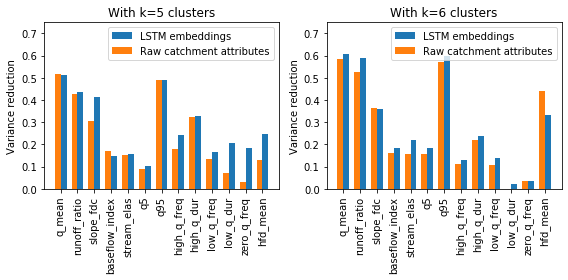

In [13]:
# Calculate and plot the results
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
for i, k in enumerate([5,6]):
    var_reduction = get_variance_reduction(clusters[k]["lstm"], clusters[k]["raw"], df_q)
    raw_vals = pd.concat([s for s in var_reduction["raw"].values()], axis=1).mean(axis=1)
    lstm_vals = pd.concat([s for s in var_reduction["lstm"].values()], axis=1).mean(axis=1)
    ind = np.arange(len(raw_vals))  # the x locations for the groups
    width = 0.35  # the width of the bars
    rects2 = ax[i].bar(ind + width/2, 1 - lstm_vals.values, width, 
                    label='LSTM embeddings')
    rects1 = ax[i].bar(ind - width/2, 1 - raw_vals.values, width,
                    label='Raw catchment attributes')
    

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax[i].set_ylabel('Variance reduction')
    ax[i].set_xticks(ind)
    ax[i].set_xticklabels(raw_vals.index)
    ax[i].tick_params(axis='x', rotation=90)
    ax[i].set_title(f"With k={k} clusters")
    ax[i].legend()
    ax[i].set_ylim(0,0.75)
plt.tight_layout()

# Embedding visualization using UMAP
Next we use a dimension reduction technique called [UMAP](https://umap-learn.readthedocs.io/en/latest/) to visualize the 256-dimensional basin embedding in 2d space. In this plot, the basins are colored by some attributes to see if the basin groupings make some kind of sense.

In [14]:
# Calculate UMAP embedding from the LSTM catchment embeddings
transformer = umap.UMAP(n_neighbors=10, 
                        min_dist=0.1, 
                        n_components=2,
                        random_state=0).fit(stacked_embedding)
umap_embedding = transformer.transform(stacked_embedding)

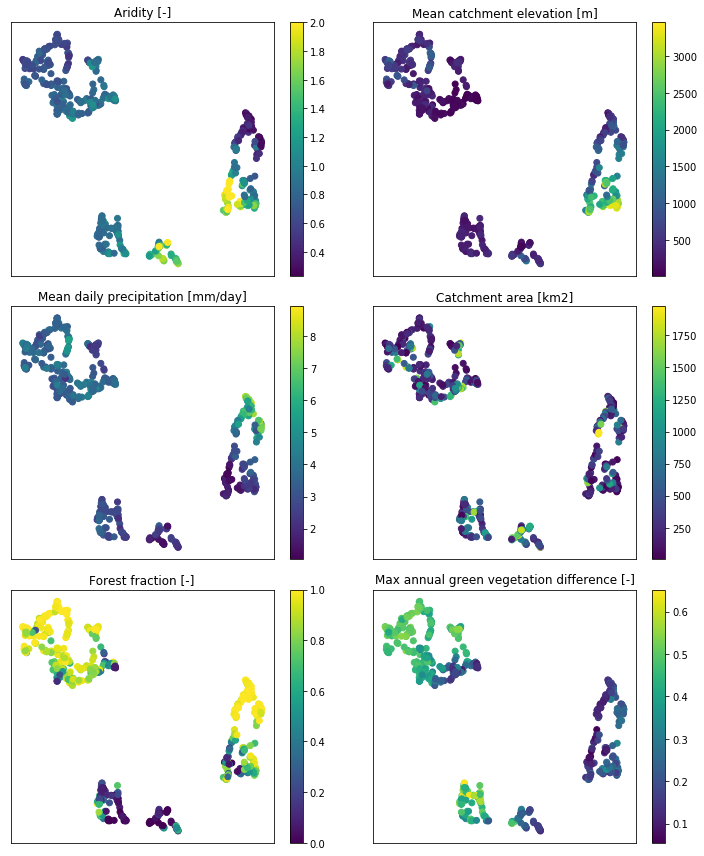

In [15]:
# Plot the results
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(10,12))

attribute_set = {'aridity': 'Aridity [-]', 
                 'elev_mean': 'Mean catchment elevation [m]', 
                 'p_mean': 'Mean daily precipitation [mm/day]', 
                 'area_gages2': 'Catchment area [km2]', 
                 'frac_forest': 'Forest fraction [-]', 
                 'gvf_diff': 'Max annual green vegetation difference [-]'}
for i, (attribute, title) in enumerate(attribute_set.items()):
    m = i // 2
    n = i % 2
    norm = colors.Normalize(vmin=attributes[attribute].min(), 
                            vmax=2 if attribute == 'aridity' else attributes[attribute].max())
    c = []
    for basin in basins:
        c.append(attributes.loc[attributes.index == basin, attribute].values[0])
    points = ax[m,n].scatter(umap_embedding[:,0], umap_embedding[:,1], c=c, norm=norm, label="Basins")
    ax[m,n].set_title(title)
    ax[m,n].set_xticks([], [])
    ax[m,n].set_yticks([], [])
    plt.colorbar(points, ax=ax[m,n])
plt.tight_layout()